In [1]:
import os
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import csv
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")

# Data Import

In [2]:
path = r"data\train.csv"
df = pd.read_csv(path, encoding = "ISO-8859-1")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


Apply pre-processing as indicated in Exploratory_Data_Analysis notebook.

In [3]:
df["Postal Code"] = df["Postal Code"].fillna(5401)
df["Order Date"] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df["Ship Date"] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')
df_changed = df.drop(columns=["Row ID", "Country"])


# Time Series Analysis
Okay. So now let's finally analyse the time series data further. Let's see if there are any time related patterns in the data where we could learn something from!

In [4]:
df_datetime = df_changed.set_index("Order Date")
df_datetime.head()

,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Order Date,,,,,,,,,,,,,,,
2017-11-08,CA-2017-152156,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
2017-11-08,CA-2017-152156,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2017-06-12,CA-2017-138688,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
2016-10-11,US-2016-108966,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
2016-10-11,US-2016-108966,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


As a first step, the sales are plotted against the Order Date. This should help to gain some insights whether the sales are having some seasonal components or not.

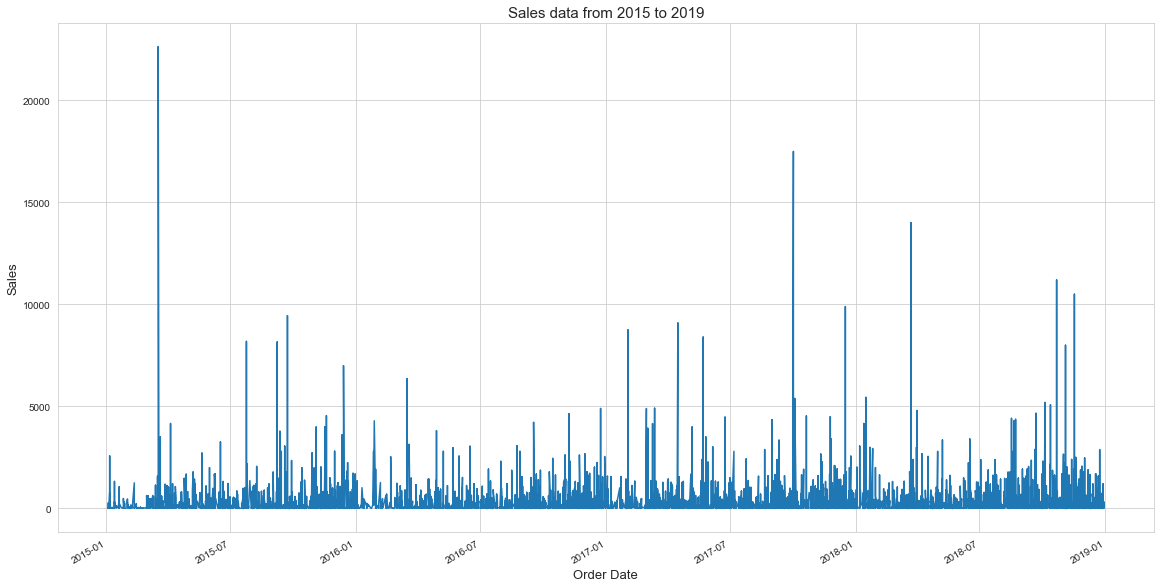

In [5]:
plt.figure(figsize=(16, 8))
df_datetime["Sales"].plot()
plt.tight_layout()
plt.title("Sales data from 2015 to 2019", size=15)
plt.ylabel("Sales", size=13)
plt.xlabel("Order Date", size=13)
plt.savefig(r"figures\sales_full_time.pdf")
plt.show()

Let's check the frequency of our data. We want to have daily sales data and only one value per day!

In [6]:
print('\nUnique dates in our data: ', len(df_datetime.index.unique()), 'Days')
our_date_range = df_datetime.index.max() - df_datetime.index.min()

# Calculate number of days in date range
print('Total days in our date range:', our_date_range.days, 'Days')


Unique dates in our data:  1230 Days
Total days in our date range: 1457 Days


In [7]:
# create daily data and replace NaN values, caused by missing days, with the linear interpolation of the days around
daily_sales = pd.DataFrame(df_datetime["Sales"].resample('D').mean()).interpolate(method='linear')
daily_sales.head(10)

,Sales
Order Date,
2015-01-03,16.448000
2015-01-04,96.020000
2015-01-05,19.536000
2015-01-06,489.677778
2015-01-07,43.579000
2015-01-08,31.925500
2015-01-09,20.272000
2015-01-10,27.415000
2015-01-11,9.940000


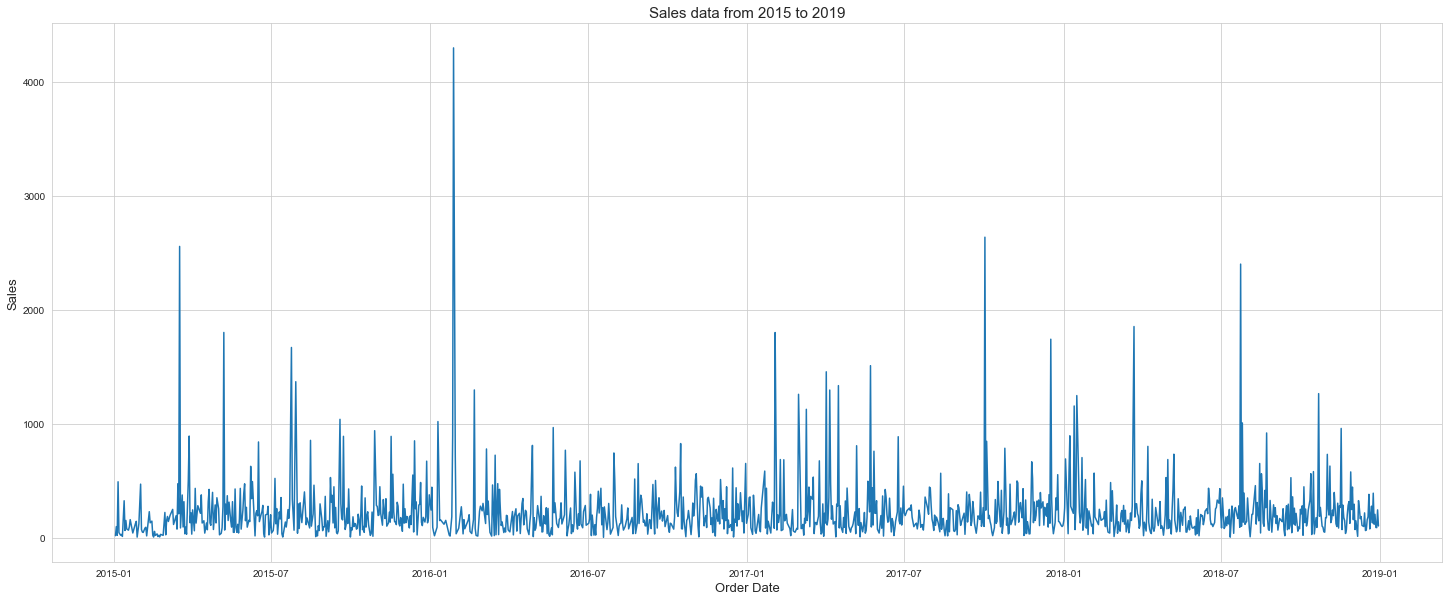

In [9]:
fig = plt.figure(figsize=(20, 8))
plt.plot(daily_sales.index, daily_sales["Sales"])
plt.tight_layout()
plt.title("Sales data from 2015 to 2019", size=15)
plt.ylabel("Sales", size=13)
plt.xlabel("Order Date", size=13)
plt.savefig(r"figures\daily_sales_full_time.pdf")
plt.show()

Looks way better now. Let's reduce the timeframe to only display the yearly sales data.

<ipython-input-14-b38e2654ad0c>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(daily_sales[year].index, daily_sales[year]["Sales"])
<ipython-input-14-b38e2654ad0c>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(daily_sales[year].index, daily_sales[year]["Sales"])
<ipython-input-14-b38e2654ad0c>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(daily_sales[year].index, daily_sales[year]["Sales"])
<ipython-input-14-b38e2654ad0c>:5: FutureWarning: Indexing a Dat

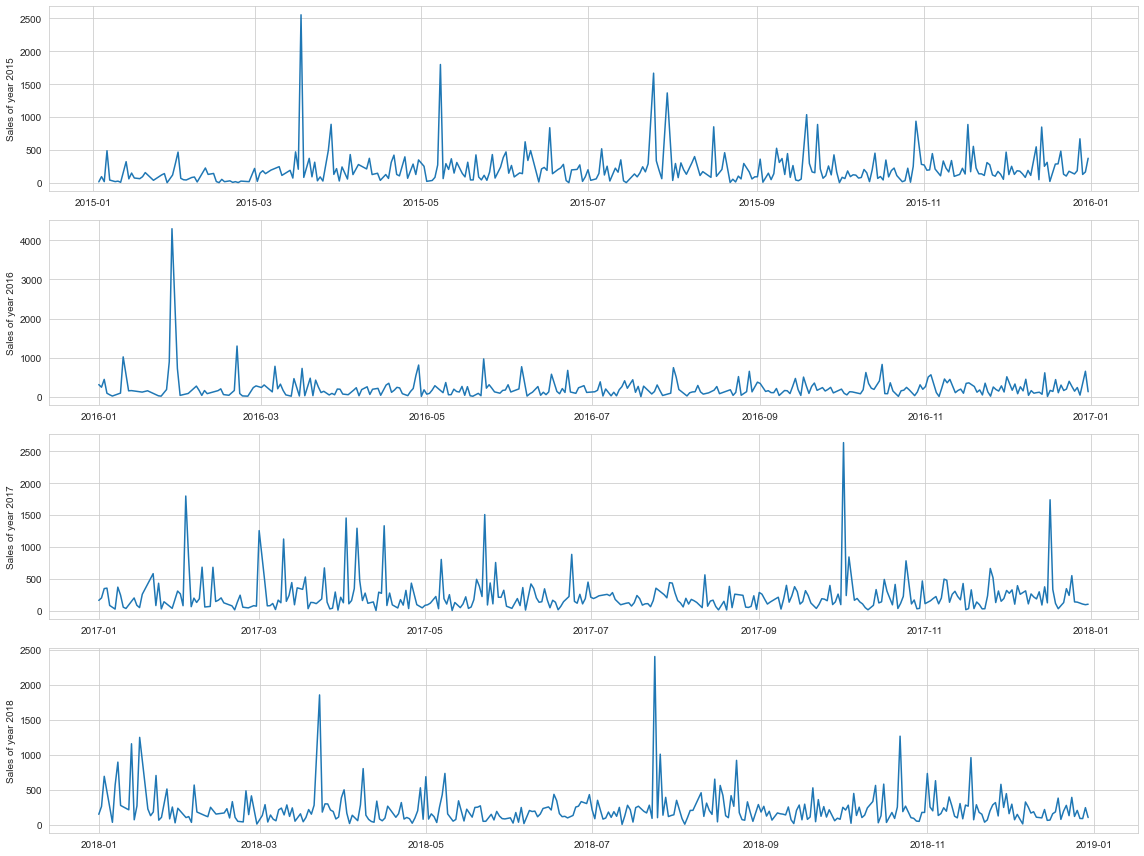

In [14]:
fig = plt.figure(figsize = (16, 12))
years = ["2015", "2016", "2017", "2018"]
for idx, year in enumerate(years):
    plt.subplot(len(years), 1, idx+1)
    plt.plot(daily_sales[year].index, daily_sales[year]["Sales"])
    plt.ylabel(f"Sales of year {year}")
plt.tight_layout()
plt.savefig(r"figures\yearly_sales_data_subplot.pdf")
plt.show()

## Stationarity
The time series looks quite stationar. But let's verify that. This is important to use traditional time series forcasting models like SARIMA. <br> <br>
A time series is said to be stationary, when: 
- the mean is constant
- the variance is constant
- the autocorrelation structure is constant
- there is no periodic component

As a first method, let's split the data into smaller chunks and compute the mean and variance for each chunk. This is an easy method to first check whether the mean and the variance are approximately the same and therefore to make a quick check whether the series can be stationary or not.

In [15]:
sales_chunks = np.array_split(daily_sales["Sales"].to_numpy(), 10)

In [16]:
# compare means and variances
print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
for i, chunk in enumerate(sales_chunks, 1):
    print("{:5} | {:.6} | {:.6}".format(i, np.mean(chunk), np.var(chunk)))

Chunk | Mean    | Variance
--------------------------
    1 | 182.186 | 75354.8
    2 | 231.287 | 60772.3
    3 | 260.761 | 1.94635e+05
    4 | 186.415 | 28313.0
    5 | 207.819 | 22547.1
    6 | 257.249 | 99129.4
    7 | 209.523 | 59225.8
    8 | 248.454 | 58682.0
    9 | 221.042 | 78934.7
   10 | 220.51 | 34326.3


Okay. So the mean and the variance are not changing a lot. It's okay that they are changing a little bit, because having the same mean and variance is very unlikely. But they should not differ a lot. So let's use the Augmented Dickey-Fuller Test to check whether the series is stationary or not.

In [17]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(daily_sales["Sales"].to_numpy())

In [18]:
print(pvalue)

0.0


Nice! The p-value is 0 and is therefore smaller than 0.5. This means, that the null hypotheses (the series is non-stationary) can be rejected and we therefore have a stationary series. Let's now quickly decompose the series into trend, seasionality and residuals.

In [19]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(daily_sales["Sales"], model='additive')
estimated_trend = decomposition.trend
estimated_seasonal = decomposition.seasonal
estimated_residual = decomposition.resid

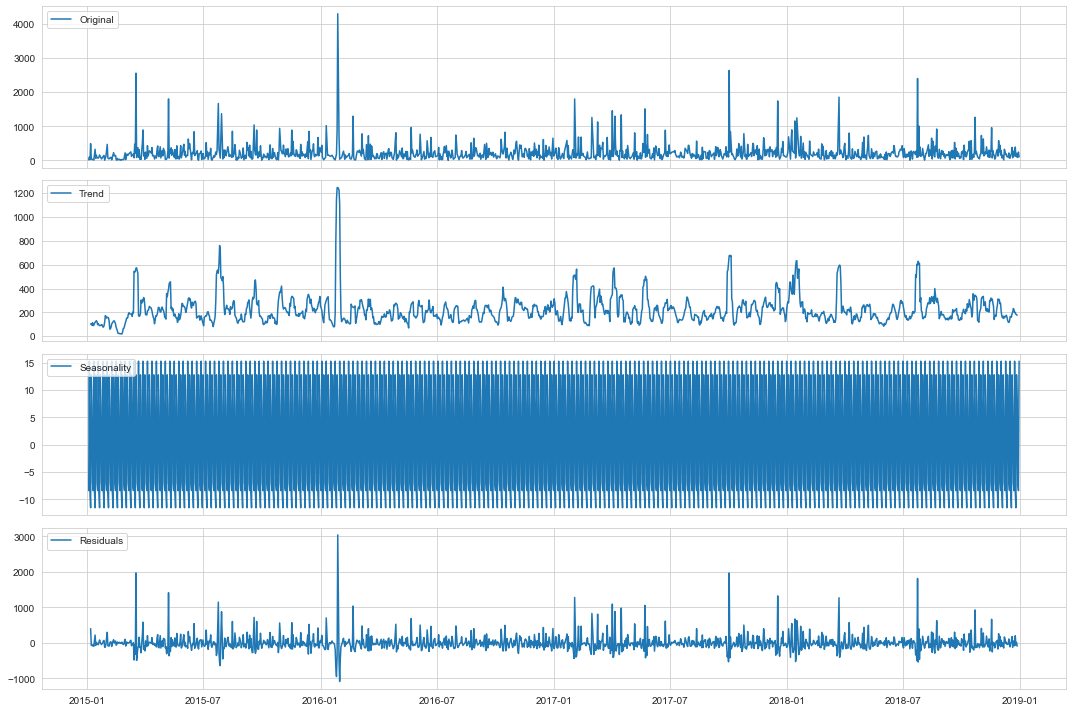

In [20]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(daily_sales["Sales"], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

plt.tight_layout()
plt.savefig(r"figures\decomposition_daily_sales.pdf")
plt.show()

Let's now fit a ARIMA model to forecast the daily sales values. <br>
The ARIMA model has some hyperparameters (p, d and q). Let's first try to find the optimal hyperparameters by performing a grid search and choosing the best hyperparameters. <br> <br>
Hyperparameters:
- p: number of AR terms
- d: number of times to difference the data
- q: number of MA terms

In [26]:
p_list = np.arange(0, 14)
q_list = np.arange(0, 14)
d_list = np.arange(0, 2) # to incooperate linear trend and exponential trend 

for d in d_list:
    for q in q_list:
        for p in p_list:
            model = ARIMA(daily_sales["Sales"], order=(p, d, q))
            results = model.fit()
            print(f"AIC for (p, d, q) = ({p}, {d}, {q}): {results.aic}")

AIC for (p, d, q) = (0, 0, 0): 20446.218363555403
AIC for (p, d, q) = (1, 0, 0): 20380.344468683463
AIC for (p, d, q) = (2, 0, 0): 20379.3336037782
AIC for (p, d, q) = (3, 0, 0): 20376.096478781285
AIC for (p, d, q) = (4, 0, 0): 20378.084732516167
AIC for (p, d, q) = (5, 0, 0): 20380.074230259394
AIC for (p, d, q) = (6, 0, 0): 20381.955937975807
AIC for (p, d, q) = (7, 0, 0): 20383.388121296615
AIC for (p, d, q) = (8, 0, 0): 20385.31080460496
AIC for (p, d, q) = (9, 0, 0): 20387.032350288297
AIC for (p, d, q) = (10, 0, 0): 20388.780832533717
AIC for (p, d, q) = (11, 0, 0): 20389.05735688267
AIC for (p, d, q) = (12, 0, 0): 20389.780760702437
AIC for (p, d, q) = (13, 0, 0): 20391.490269776124
AIC for (p, d, q) = (0, 0, 1): 20389.27366929675
AIC for (p, d, q) = (1, 0, 1): 20380.442792748378


C:\Users\brusp\.conda\envs\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\brusp\.conda\envs\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC for (p, d, q) = (2, 0, 1): 20378.098179473058
AIC for (p, d, q) = (3, 0, 1): 20378.083412064298
AIC for (p, d, q) = (4, 0, 1): 20380.086614099477
AIC for (p, d, q) = (5, 0, 1): 20382.07972423067
AIC for (p, d, q) = (6, 0, 1): 20383.797200074732
AIC for (p, d, q) = (7, 0, 1): 20385.360502132542
AIC for (p, d, q) = (8, 0, 1): 20387.336118510655
AIC for (p, d, q) = (9, 0, 1): 20388.994825939597
AIC for (p, d, q) = (10, 0, 1): 20390.46522087446
AIC for (p, d, q) = (11, 0, 1): 20390.42575696317


KeyboardInterrupt: 

In [25]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(daily_sales["Sales"], order=(2, 0, 0))
results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        222.5269     13.572     16.396      0.000     195.927     249.127
ar.L1          0.2036      0.010     19.403      0.000       0.183       0.224
ar.L2          0.0454      0.024      1.863      0.062      -0.002       0.093
sigma2      6.853e+04    725.469     94.470      0.000    6.71e+04       7e+04
